# Main

this notebook is the main file of the project, here the model are trained and evaluated

# Import libraies

In [35]:
#coustom modules
from train import Trainer
from models import Generator, Critic
import data.data_preprocessing as data_prep
import utils
from rescale_generated import Rescale

#pytorch modules
import torch
from torch.utils.data import DataLoader

#general modules
import matplotlib.pyplot as plt
import numpy as np

# Create the dataset

The following function transform the data bere using them as input for the model.

In [40]:
#create the transformer to scale the series
class ScaleInput:
    
    def __init__(self, scale) -> None:
        self.scale = scale

    def __call__(self, sample):
        return sample * self.scale

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

class Magnitude_Scaler:

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):

        cap = torch.max(sample)
        bottom = torch.min(sample)

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (self.scale[1] - self.scale[0]) + self.scale[0]
        
        return X_scaled

the following code create the dataset and plot some sample of the dataset series

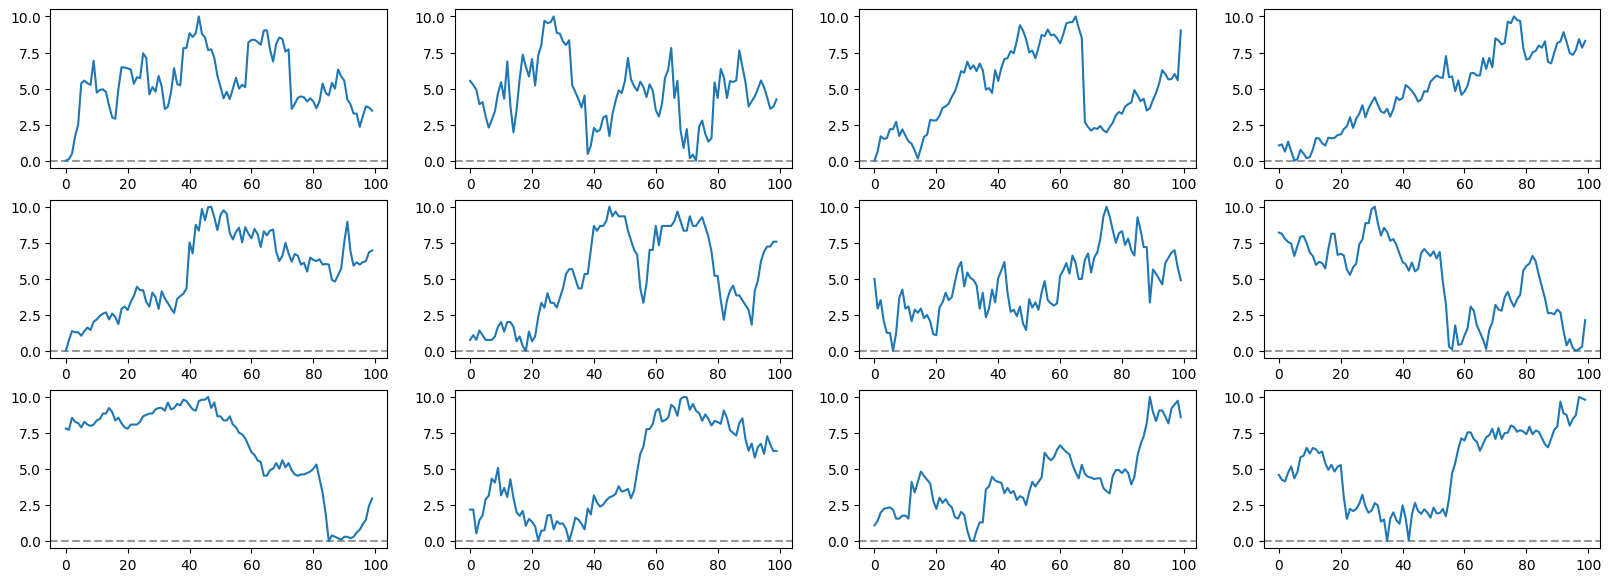

In [41]:
#initialize the transformer
scaler_p = Magnitude_Scaler([0,10])
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_price',transform = scaler_p)

#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(20,7))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

# Model initialization and training

the following box of code contains all the hyperparameters for the model training

In [43]:
#chose the Base directiory to save the run
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
G_NORM_PEN = 5
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = utils.create_dir(BASE_DIR,'price_001')

The following is the core of model training:

run the following cell to further train a model

In [2]:
# Instantiate Generator and Critic + initialize weights
from checkpoints import models as models_test
state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))

g = models_test.Generator()
g.load_state_dict(state_dicts['g_state_dict'])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
#adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
#grater for discriminator the lr


c = models_test.Critic()
c.load_state_dict(state_dicts['d_state_dict'])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)


run the following cell to train a new model

In [44]:
g = Generator()
#g_opt = torch.optim.Adam(g.parameters(), lr=0.003, betas=[0.5, 0.99])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

c = Critic()
#c_opt = torch.optim.Adam(c.parameters(), lr=0.009, betas=[0.5, 0.99])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

The following code train the model.

In [45]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,G_NORM_PEN,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

Training is about to start...


100%|██████████| 40/40 [48:44<00:00, 73.11s/it]  


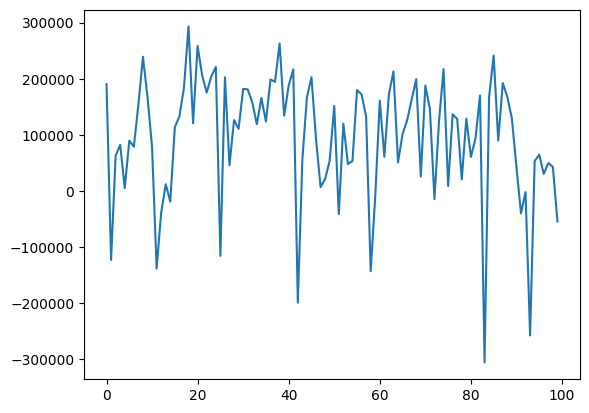

In [58]:
sample = utils.generate_sample(g,10)

plt.plot(sample[1][0].detach().numpy())

# Evaluate the model

the following code rescale use the model to generate samples of returns and plot the results

In [6]:
import importlib
importlib.reload(utils)


<module 'utils' from 'c:\\Users\\bolla\\Desktop\\CUHK_courses\\IASP_elisa\\final\\utils.py'>

In [3]:
#create a non-transformed dataset to initialize the rescaler
plain_dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')
#initialize the rescaler
rescaler = Rescale(plain_dataset, picks_range=0.02)

~Scaler initialization~
~computing the min and max quantiles~


100%|██████████| 10353/10353 [02:47<00:00, 61.81it/s]


~computing the distance between peaks~


100%|██████████| 10353/10353 [01:21<00:00, 126.33it/s]


In [14]:
import math

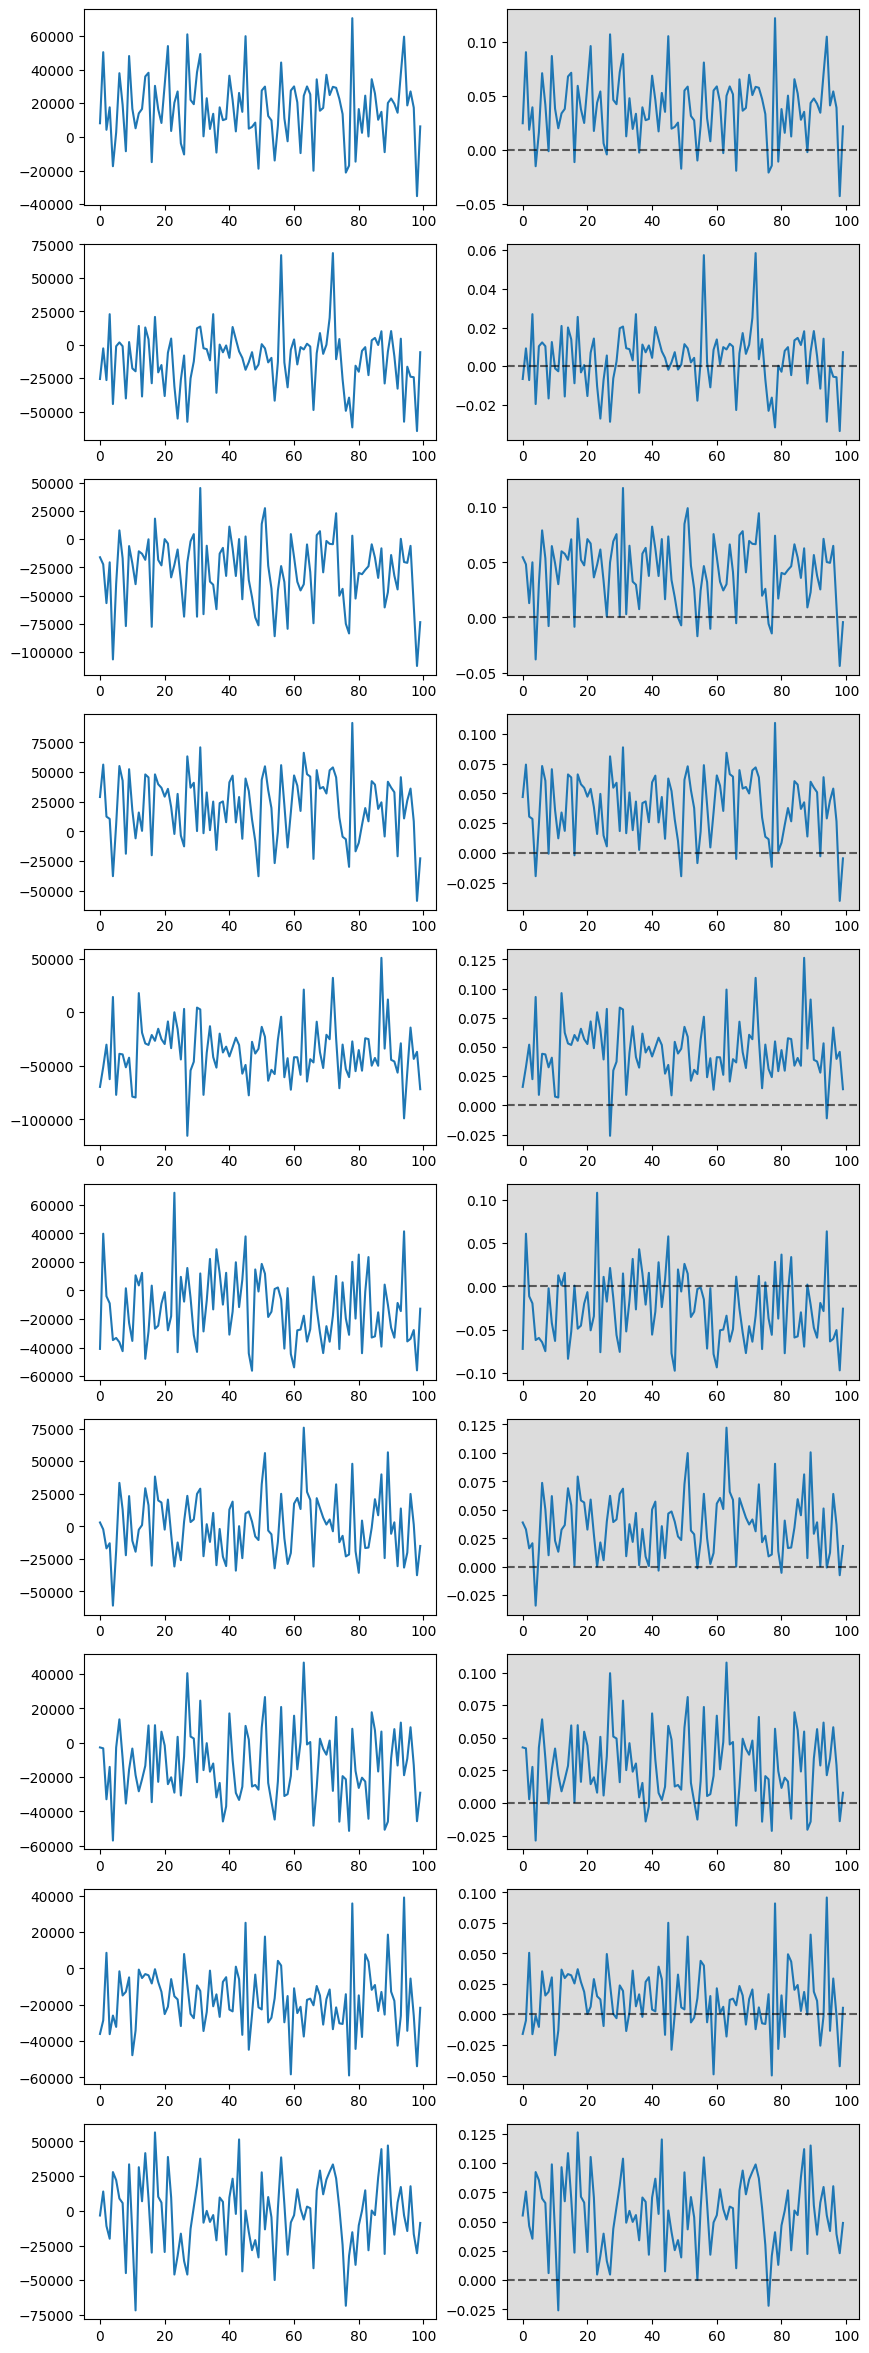

In [32]:
sample = utils.generate_sample(g,10)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))

fig, axs = plt.subplots(len(sample),2)
fig.set_figheight(3*len(sample))
fig.set_figwidth(10)

for i,ax in enumerate(axs):
    sample[i] = sample[i].detach().numpy()
    ax[0].plot(sample[i][0])
    ax[1].plot(scaled[i])
    ax[1].axhline(0, color='black', ls='--', alpha = 0.6)
    ax[1].set_facecolor('gainsboro')

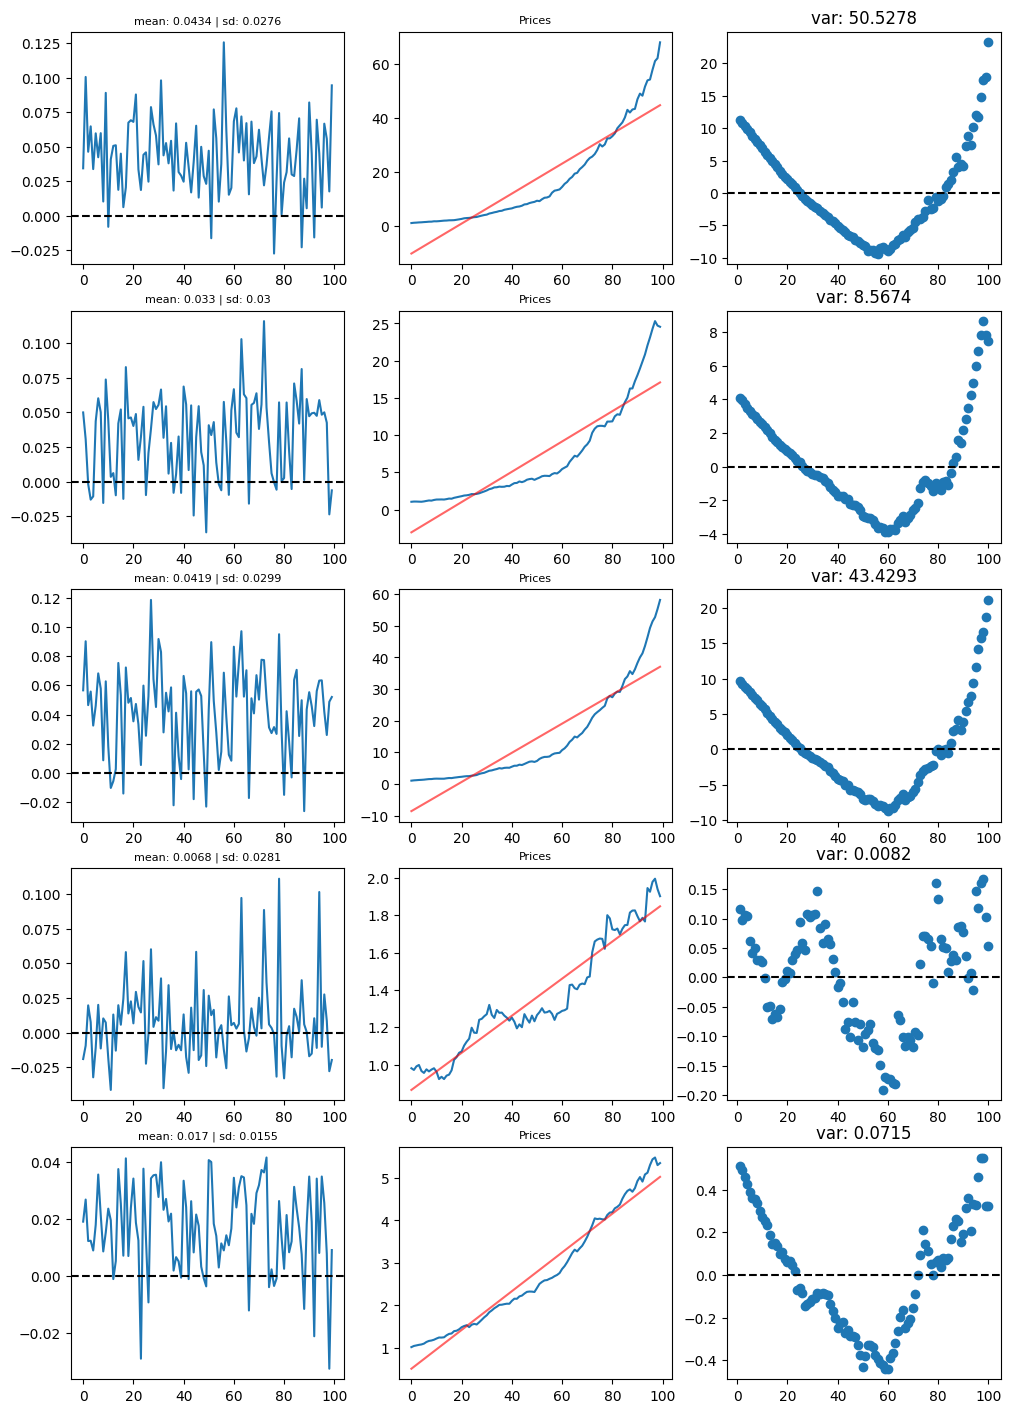

In [7]:
sample = utils.generate_sample(g,5)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))
    
prices, residuals, params = utils.plot_samples_price(scaled, save='results/pure_1.png', return_series=True)

In [10]:
import importlib
import generate_syntetic_df
importlib.reload(generate_syntetic_df)
import generate_syntetic_df
from generate_syntetic_df import DfGenerator

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\bolla\\Desktop\\CUHK_courses\\IASP_elisa\\final\\utils.py'>

In [11]:
df_generator = DfGenerator(variance_th=6, mean_boundary = 0.006, max_range=0.15, generator=g, size = 10, rescaler=rescaler)
syntetic_df = df_generator()

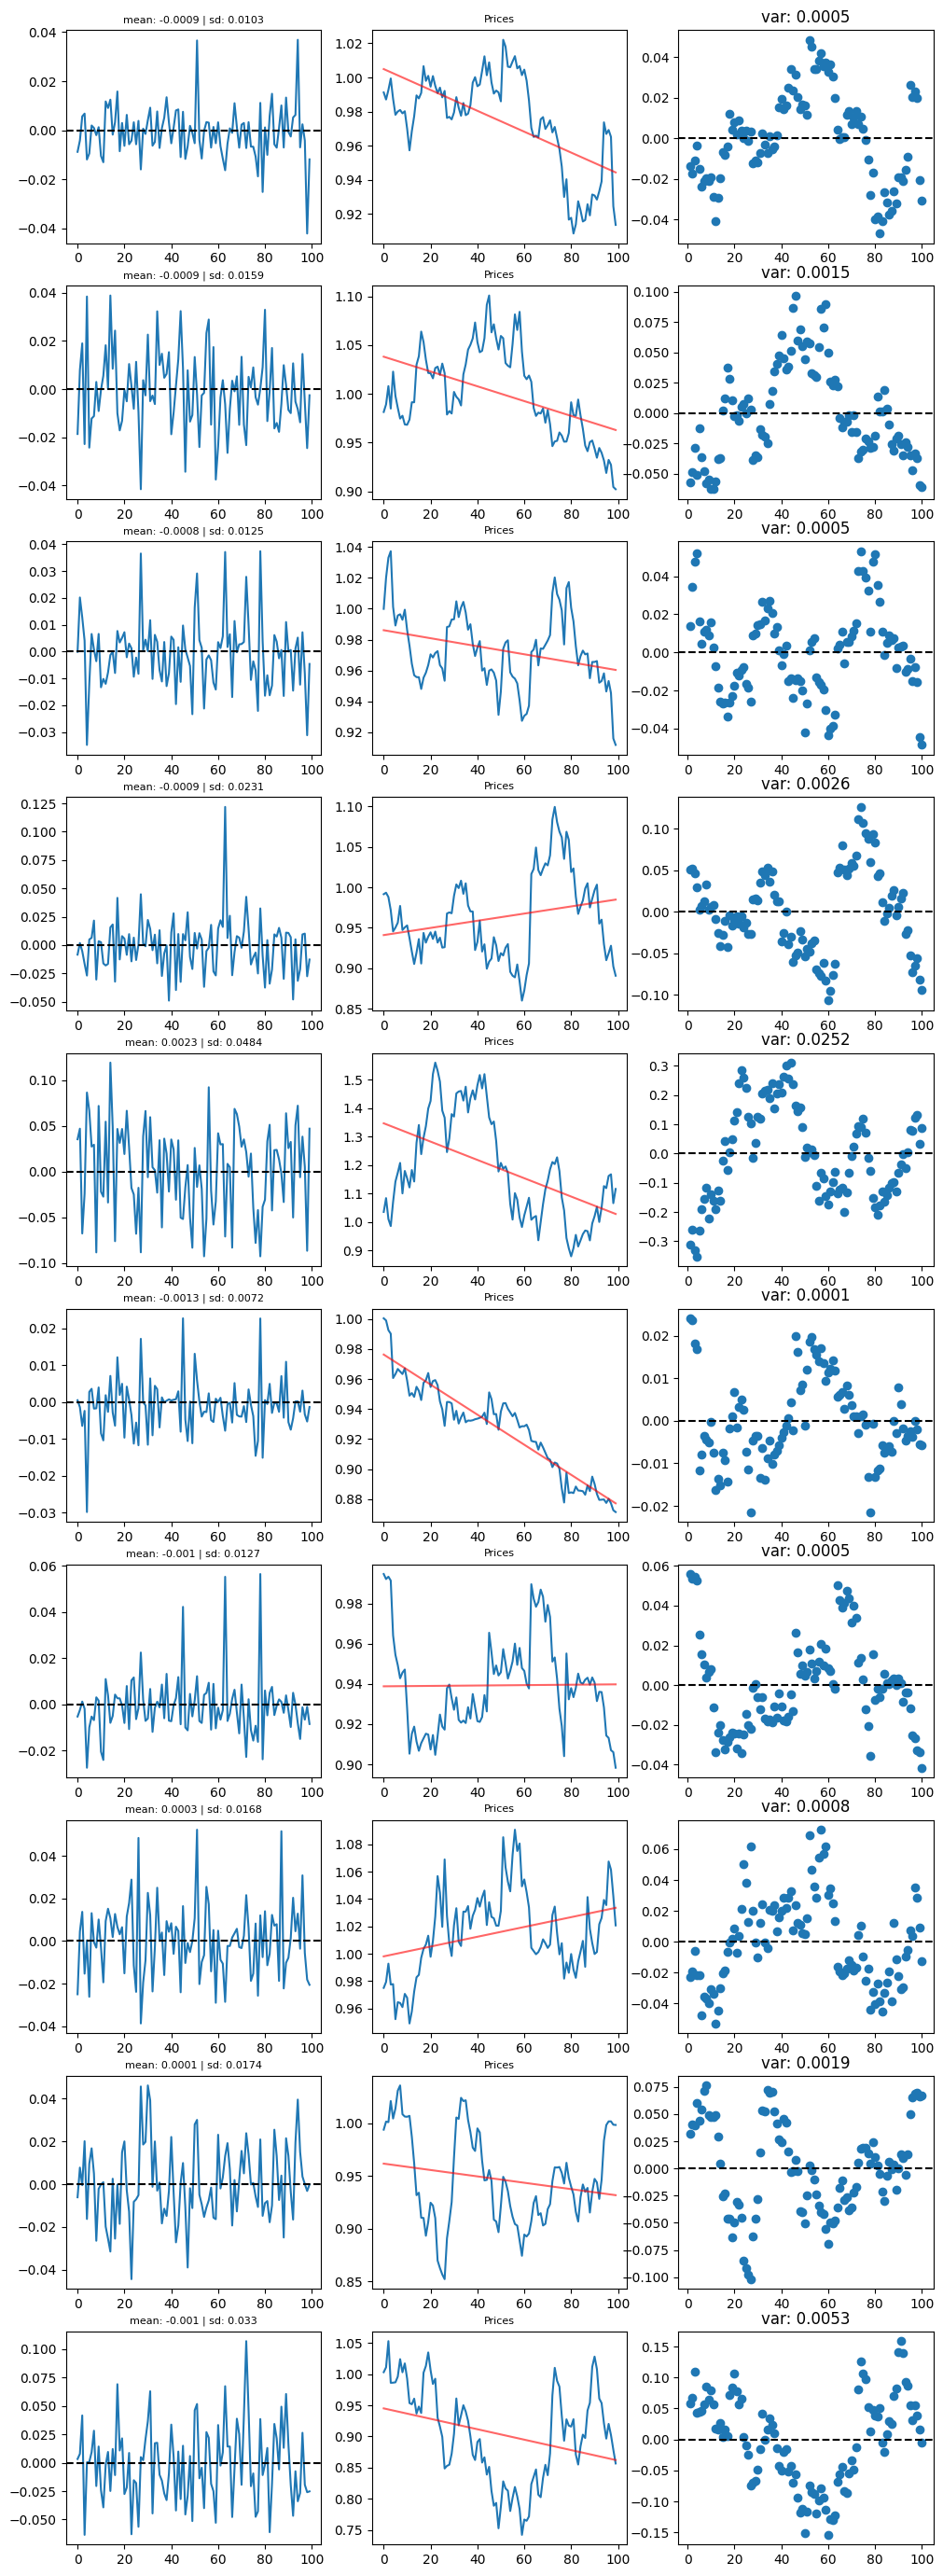

In [12]:
utils.plot_samples_price(syntetic_df, save='results/000_002.png', return_series=False)

In [258]:
import data
importlib.reload(data.data_preprocessing)
import data.data_preprocessing as data_prep